In [3]:
# !pip install xgboost
# !pip install shap
# !conda install -y -c dglteam dgl-cuda10.1
# !conda install -y pytorch torchvision cudatoolkit=10.1 -c pytorch

In [4]:
import os
from pathlib import Path

import pickle
import xgboost as xgb
import shap

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/miniconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [7]:
results_dir = '/data/results/09242020_model_results_appr'
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [8]:
df = pd.read_csv('/data/results/09232020_data_prep/acetyl_phospho_proteome_rnaseq_processed.tsv',
                 sep='\t', index_col='Unnamed: 0')
df

,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc,is_driver,is_oncogene,is_tsg,cancer_type
ACIN1_C3N-01799,0.687550,0.188575,0.498975,0.151535,-0.209620,0.361155,0.151535,-0.209620,0.361155,24.947247,17.928953,1.370770,0.0,0.0,0.0,LUAD
ACLY_C3N-01799,0.397156,0.096444,0.300711,1.761150,0.269400,1.491750,1.761150,0.269400,1.491750,49.074934,23.936849,2.008070,0.0,0.0,0.0,LUAD
ACOX1_C3N-01799,-1.454800,-1.994000,0.539200,-1.228900,-2.360000,1.131100,-1.228900,-2.360000,1.131100,23.585992,16.541906,1.401558,0.0,0.0,0.0,LUAD
ACSL3_C3N-01799,0.066433,0.388700,-0.322267,-0.412300,-0.677500,0.265200,-0.412300,-0.677500,0.265200,15.517216,21.480543,0.734734,0.0,0.0,0.0,LUAD
ACTN1_C3N-01799,-0.381100,-0.080925,-0.300175,-0.684000,1.424622,-2.108622,-0.684000,1.424622,-2.108622,12.608740,10.549377,1.178309,0.0,0.0,0.0,LUAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF292_C3L-02349,0.376867,-0.785200,1.162067,-1.489850,-1.747625,0.257775,-1.489850,-1.747625,0.257775,9.175416,10.940414,0.852183,0.0,0.0,0.0,LSCC
ZNF407_C3L-02349,0.906000,1.422100,-0.516100,-0.685440,-0.272880,-0.412560,-0.685440,-0.272880,-0.412560,4.407454,6.955711,0.679695,0.0,0.0,0.0,LSCC
ZNF638_C3L-02349,1.133560,-2.044240,3.177800,0.254800,-0.324489,0.579289,0.254800,-0.324489,0.579289,30.060677,24.283453,1.228498,0.0,0.0,0.0,LSCC
ZNF740_C3L-02349,0.331800,-0.398233,0.730033,0.557900,0.836800,-0.278900,0.557900,0.836800,-0.278900,10.811067,6.972168,1.481538,0.0,0.0,0.0,LSCC


In [61]:
# df = df[[c for c in df.columns if c not in ['value', 'data_type']]]
# df.index = [x.split('_')[0] + '_' + x.split('_')[2] for x in df.index]
# df = df.drop_duplicates()

In [9]:
df['gene'] = [g.split('_')[0] for g in df.index]
df

,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc,is_driver,is_oncogene,is_tsg,cancer_type,gene
ACIN1_C3N-01799,0.687550,0.188575,0.498975,0.151535,-0.209620,0.361155,0.151535,-0.209620,0.361155,24.947247,17.928953,1.370770,0.0,0.0,0.0,LUAD,ACIN1
ACLY_C3N-01799,0.397156,0.096444,0.300711,1.761150,0.269400,1.491750,1.761150,0.269400,1.491750,49.074934,23.936849,2.008070,0.0,0.0,0.0,LUAD,ACLY
ACOX1_C3N-01799,-1.454800,-1.994000,0.539200,-1.228900,-2.360000,1.131100,-1.228900,-2.360000,1.131100,23.585992,16.541906,1.401558,0.0,0.0,0.0,LUAD,ACOX1
ACSL3_C3N-01799,0.066433,0.388700,-0.322267,-0.412300,-0.677500,0.265200,-0.412300,-0.677500,0.265200,15.517216,21.480543,0.734734,0.0,0.0,0.0,LUAD,ACSL3
ACTN1_C3N-01799,-0.381100,-0.080925,-0.300175,-0.684000,1.424622,-2.108622,-0.684000,1.424622,-2.108622,12.608740,10.549377,1.178309,0.0,0.0,0.0,LUAD,ACTN1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF292_C3L-02349,0.376867,-0.785200,1.162067,-1.489850,-1.747625,0.257775,-1.489850,-1.747625,0.257775,9.175416,10.940414,0.852183,0.0,0.0,0.0,LSCC,ZNF292
ZNF407_C3L-02349,0.906000,1.422100,-0.516100,-0.685440,-0.272880,-0.412560,-0.685440,-0.272880,-0.412560,4.407454,6.955711,0.679695,0.0,0.0,0.0,LSCC,ZNF407
ZNF638_C3L-02349,1.133560,-2.044240,3.177800,0.254800,-0.324489,0.579289,0.254800,-0.324489,0.579289,30.060677,24.283453,1.228498,0.0,0.0,0.0,LSCC,ZNF638
ZNF740_C3L-02349,0.331800,-0.398233,0.730033,0.557900,0.836800,-0.278900,0.557900,0.836800,-0.278900,10.811067,6.972168,1.481538,0.0,0.0,0.0,LSCC,ZNF740


In [10]:
list(df.columns)

['acetyl_tumor',
 'acetyl_normal',
 'acetyl_difference',
 'phospho_tumor',
 'phospho_normal',
 'phospho_difference',
 'proteome_tumor',
 'proteome_normal',
 'proteome_difference',
 'rnaseq_tumor',
 'rnaseq_normal',
 'rnaseq_fc',
 'is_driver',
 'is_oncogene',
 'is_tsg',
 'cancer_type',
 'gene']

In [13]:
np.count_nonzero(df['is_driver']), np.count_nonzero(df['is_oncogene']), np.count_nonzero(df['is_tsg'])  

(614, 6, 596)

In [20]:
len(set(df[df['is_tsg']==1]['gene']))

9

In [15]:
df[df['is_driver']==1]

,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc,is_driver,is_oncogene,is_tsg,cancer_type,gene
ARID1A_C3N-01799,-0.109625,-0.613333,0.503708,-0.157318,0.096059,-0.253376,-0.157318,0.096059,-0.253376,19.439649,8.517221,2.147649,1.0,0.0,1.0,LUAD,ARID1A
SMARCA4_C3N-01799,0.993700,0.003900,0.989800,-0.112979,-2.317492,2.204513,-0.112979,-2.317492,2.204513,19.653784,6.371917,2.801684,1.0,0.0,1.0,LUAD,SMARCA4
ARID1A_C3L-01890,-1.596167,-1.037200,-0.558967,0.293524,-0.216382,0.509906,0.293524,-0.216382,0.509906,16.847714,11.918272,1.381587,1.0,0.0,1.0,LUAD,ARID1A
SMARCA4_C3L-01890,-0.789650,-1.119350,0.329700,-0.345771,-2.121843,1.776071,-0.345771,-2.121843,1.776071,19.495869,8.951758,2.059522,1.0,0.0,1.0,LUAD,SMARCA4
ARID1A_C3N-00572,0.306600,-0.467100,0.773700,0.473424,0.303047,0.170376,0.473424,0.303047,0.170376,9.871771,9.428395,1.042516,1.0,0.0,1.0,LUAD,ARID1A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KMT2D_C3N-03851,-0.352820,-0.584770,0.231950,-0.539774,0.471300,-1.011074,-0.539774,0.471300,-1.011074,4.710050,7.316184,0.686619,1.0,0.0,1.0,LSCC,KMT2D
ARID1A_C3L-02349,-0.045750,0.613750,-0.659500,-0.583861,-0.434318,-0.149543,-0.583861,-0.434318,-0.149543,9.833932,11.554134,0.862977,1.0,0.0,1.0,LSCC,ARID1A
EP300_C3L-02349,0.533140,-1.079740,1.612880,0.307375,0.037612,0.269763,0.307375,0.037612,0.269763,16.410160,16.995301,0.967484,1.0,0.0,1.0,LSCC,EP300
KDM6A_C3L-02349,0.936450,-0.045300,0.981750,0.527440,0.572040,-0.044600,0.527440,0.572040,-0.044600,14.954368,15.593156,0.961503,1.0,0.0,1.0,LSCC,KDM6A


In [16]:
# df[df['is_tsg']==1]

In [18]:
def sample_rows(df, key, value, train_n, test_n):
    idxs = np.asarray([i for i, x in enumerate(df[key]) if value==x])
    train_idxs = np.random.choice(idxs, size=train_n, replace=False) if train_n < len(idxs) else idxs
    mask = np.full((df.shape[0],), True)
    for i in train_idxs: mask[i] = False

    idxs = np.asarray([i for (i, x), m in zip(enumerate(df[key]), mask) if value==x if m])
    test_idxs = np.random.choice(idxs, size=test_n, replace=False) if test_n < len(idxs) else idxs
    return df.iloc[train_idxs, :], df.iloc[test_idxs, :]


def train_test_by_gene(df, key, value, train_n):
    drivers = df[df[key]==value]
    genes = sorted(set(drivers['gene']))
    train_genes = np.random.choice(genes, size=train_n, replace=False)
    test_genes = [g for g in genes if g not in train_genes]
    
    return (df[[True if g in train_genes else False for g in df['gene']]],
            df[[True if g in test_genes else False for g in df['gene']]])
    

def transform_categorical(df, cols):
    for c in cols:
        ls = df[c].to_list()
        vals = sorted(set(ls))
        for val in vals:
            df[f'{c}_is_{val}'] = [True if val == x else False for x in ls]
            
    return df[[c for c in df.columns if c not in cols]]

def get_X_y(df, target, to_remove=[]):
    filtered = df[[c for c in df.columns if c not in to_remove]]
    y = np.asarray(filtered[target].to_list())
    return filtered, y

In [22]:
# driver_train, driver_test = sample_rows(df, 'driver', 1, 1500, 500)
# def train_test_by_gene(df, key, value, train_n, test_n=None):
driver_train, driver_test = train_test_by_gene(df, 'is_tsg', 1, 5)
nondriver_train, nondriver_test = train_test_by_gene(df, 'is_tsg', 0, 10)

# nondriver_train, nondriver_test = sample_rows(df, 'driver', 0, 10000, 500)

train = pd.concat((driver_train, nondriver_train), axis=0)
test = pd.concat((driver_test, nondriver_test), axis=0)

train, test = train.sample(frac=1), test.sample(frac=1)

train_X, train_y = get_X_y(train, 'is_tsg', to_remove=['gene', 'is_oncogene', 'is_driver', 'cancer_type'])
test_X, test_y = get_X_y(test, 'is_tsg', to_remove=['gene', 'is_oncogene', 'is_driver', 'cancer_type'])

# train_X, test_X = (transform_categorical(train_X, ['sample_type']),
#                    transform_categorical(test_X, ['sample_type']))

## remove driver for inputs
train_X, test_X = (train_X[[c for c in train_X.columns if c != 'is_tsg']],
                   test_X[[c for c in test_X.columns if c != 'is_tsg']])

In [77]:
# driver_train, driver_test = sample_rows(df, 'driver', 1, 1500, 500)
# nondriver_train, nondriver_test = sample_rows(df, 'driver', 0, 10000, 500)

# train = pd.concat((driver_train, nondriver_train), axis=0)
# test = pd.concat((driver_test, nondriver_test), axis=0)

# train, test = train.sample(frac=1), test.sample(frac=1)

# train_X, train_y = get_X_y(train, 'driver', to_remove=['gene', 'expanded_driver'])
# test_X, test_y = get_X_y(test, 'driver', to_remove=['gene', 'expanded_driver'])

# train_X, test_X = (transform_categorical(train_X, ['sample_type', 'data_type']),
#                    transform_categorical(test_X, ['sample_type', 'data_type']))

# ## remove driver for inputs
# train_X, test_X = (train_X[[c for c in train_X.columns if c != 'driver']],
#                    test_X[[c for c in test_X.columns if c != 'driver']])

In [23]:
train_X

,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc
VAPA_C3N-00203,1.213200,-1.684200,2.897400,-0.557600,-0.053400,-0.504200,-0.557600,-0.053400,-0.504200,18.467450,19.641106,0.943140
SRFBP1_C3N-00578,1.079800,-0.133700,1.213500,-0.142950,-1.942050,1.799100,-0.142950,-1.942050,1.799100,7.502364,6.788368,1.091675
PLPBP_C3L-00993,1.944800,0.095100,1.849700,2.271000,-0.104500,2.375500,2.271000,-0.104500,2.375500,55.449560,11.792775,4.412613
CDK1_C3N-00199,2.287700,-1.434000,3.721700,2.084000,-3.340650,5.424650,2.084000,-3.340650,5.424650,6.206452,1.251350,3.200947
SRFBP1_C3N-02149,0.529500,0.297700,0.231800,0.912520,-1.331320,2.243840,0.912520,-1.331320,2.243840,6.809941,6.918930,0.986237
...,...,...,...,...,...,...,...,...,...,...,...,...
PRDX6_C3L-00009,-0.477860,-0.342020,-0.135840,-0.900550,0.200200,-1.100750,-0.900550,0.200200,-1.100750,49.829258,47.627921,1.045269
HNRNPH1_C3N-00433,0.330400,-0.549700,0.880100,-0.421229,-0.981286,0.560057,-0.421229,-0.981286,0.560057,78.179768,70.942429,1.100599
PRDX6_C3N-01892,0.181060,0.230880,-0.049820,-1.203300,1.066700,-2.270000,-1.203300,1.066700,-2.270000,90.516583,57.054940,1.576379
KMT2C_C3L-02951,0.895479,-1.922764,2.818243,0.080595,-0.265705,0.346300,0.080595,-0.265705,0.346300,19.990594,23.442208,0.858785


In [24]:
test_X

,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc
SRSF7_C3N-02729,-0.419950,-0.129650,-0.290300,-1.030100,-1.920120,0.890020,-1.030100,-1.920120,0.890020,27.233519,39.589492,0.695587
CAPN1_C3N-03486,-0.444040,0.114280,-0.558320,-0.160333,0.449667,-0.610000,-0.160333,0.449667,-0.610000,42.076119,16.372723,2.479526
HSPA5_C3N-02433,-1.259667,0.220967,-1.480633,0.598833,-0.633967,1.232800,0.598833,-0.633967,1.232800,83.391034,43.243325,1.907430
MEF2D_C3L-02163,-0.243400,1.228400,-1.471800,0.096300,0.570875,-0.474575,0.096300,0.570875,-0.474575,7.733968,13.396616,0.606668
CNN1_C3N-01411,1.333250,1.039800,0.293450,-1.431400,-0.704100,-0.727300,-1.431400,-0.704100,-0.727300,4.055306,13.166920,0.356839
...,...,...,...,...,...,...,...,...,...,...,...,...
UBN2_C3N-02252,0.550667,-1.810633,2.361300,0.875233,-1.858633,2.733867,0.875233,-1.858633,2.733867,6.420186,5.935684,1.069856
ATOX1_C3N-01410,-0.106800,0.593500,-0.700300,0.099000,0.635400,-0.536400,0.099000,0.635400,-0.536400,4.196852,5.289652,0.826254
CHRDL1_C3L-02164,-1.062333,-0.032900,-1.029433,0.153100,0.071200,0.081900,0.153100,0.071200,0.081900,16.600681,18.936225,0.882849
SMARCA2_C3N-00549,1.180167,-0.419133,1.599300,0.099085,0.328054,-0.228969,0.099085,0.328054,-0.228969,10.913656,32.262880,0.358167


In [25]:
list(train_X.columns)

['acetyl_tumor',
 'acetyl_normal',
 'acetyl_difference',
 'phospho_tumor',
 'phospho_normal',
 'phospho_difference',
 'proteome_tumor',
 'proteome_normal',
 'proteome_difference',
 'rnaseq_tumor',
 'rnaseq_normal',
 'rnaseq_fc']

In [26]:
train_y

array([0., 0., 0., ..., 0., 0., 1.])

In [62]:
clf = xgb.XGBClassifier(random_state=42)
model = clf.fit(train_X, train_y)

In [63]:
model.score(train_X, train_y)

1.0

In [64]:
model.score(test_X, test_y)

0.8813604644141774

In [65]:
from sklearn.metrics import classification_report

In [66]:
classification_report(test_y, model.predict(test_X), output_dict=True)

{'0.0': {'precision': 0.997767682305945,
  'recall': 0.8828248176447148,
  'f1-score': 0.9367835639104656,
  'support': 115434},
 '1.0': {'precision': 0.019499818774918447,
  'recall': 0.5412474849094567,
  'f1-score': 0.03764343688776938,
  'support': 497},
 'accuracy': 0.8813604644141774,
 'macro avg': {'precision': 0.5086337505404317,
  'recall': 0.7120361512770857,
  'f1-score': 0.4872135003991175,
  'support': 115931},
 'weighted avg': {'precision': 0.993573815883893,
  'recall': 0.8813604644141774,
  'f1-score': 0.9329289206905307,
  'support': 115931}}

In [67]:
prob_df = pd.DataFrame.from_dict({
    'groundtruth': ['driver' if x==1 else 'not driver' for x in test_y],
    'prediction': ['driver' if x==1 else 'not driver' for x in model.predict(test_X)],
    'probs': model.predict_proba(test_X)[:, 1].flatten()
})
prob_df.index = test_X.index
prob_df = pd.concat((prob_df, test_X), axis=1)
prob_df

,groundtruth,prediction,probs,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc
SRSF7_C3N-02729,not driver,not driver,0.000084,-0.419950,-0.129650,-0.290300,-1.030100,-1.920120,0.890020,-1.030100,-1.920120,0.890020,27.233519,39.589492,0.695587
CAPN1_C3N-03486,not driver,not driver,0.000909,-0.444040,0.114280,-0.558320,-0.160333,0.449667,-0.610000,-0.160333,0.449667,-0.610000,42.076119,16.372723,2.479526
HSPA5_C3N-02433,not driver,not driver,0.000960,-1.259667,0.220967,-1.480633,0.598833,-0.633967,1.232800,0.598833,-0.633967,1.232800,83.391034,43.243325,1.907430
MEF2D_C3L-02163,not driver,not driver,0.023274,-0.243400,1.228400,-1.471800,0.096300,0.570875,-0.474575,0.096300,0.570875,-0.474575,7.733968,13.396616,0.606668
CNN1_C3N-01411,not driver,not driver,0.009244,1.333250,1.039800,0.293450,-1.431400,-0.704100,-0.727300,-1.431400,-0.704100,-0.727300,4.055306,13.166920,0.356839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBN2_C3N-02252,not driver,not driver,0.016253,0.550667,-1.810633,2.361300,0.875233,-1.858633,2.733867,0.875233,-1.858633,2.733867,6.420186,5.935684,1.069856
ATOX1_C3N-01410,not driver,not driver,0.021293,-0.106800,0.593500,-0.700300,0.099000,0.635400,-0.536400,0.099000,0.635400,-0.536400,4.196852,5.289652,0.826254
CHRDL1_C3L-02164,not driver,not driver,0.001354,-1.062333,-0.032900,-1.029433,0.153100,0.071200,0.081900,0.153100,0.071200,0.081900,16.600681,18.936225,0.882849
SMARCA2_C3N-00549,not driver,not driver,0.003166,1.180167,-0.419133,1.599300,0.099085,0.328054,-0.228969,0.099085,0.328054,-0.228969,10.913656,32.262880,0.358167


In [68]:
import seaborn as sns

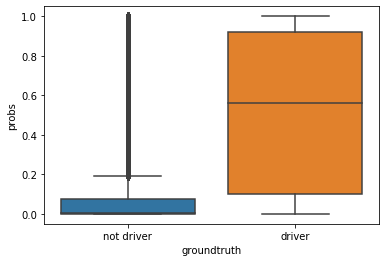

In [69]:
sns.boxplot(data=prob_df, x='groundtruth', y='probs')

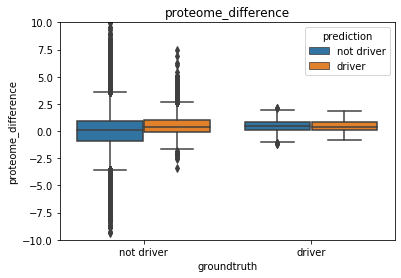

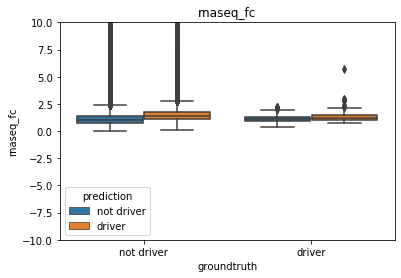

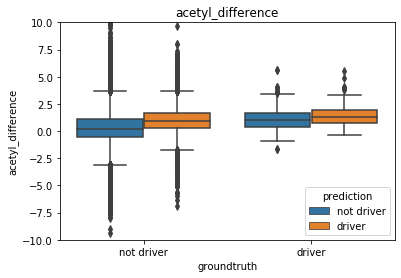

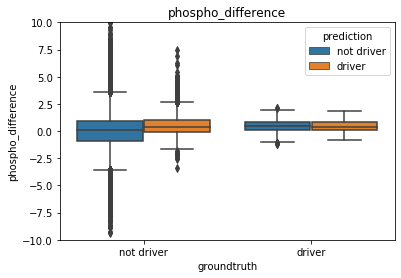

In [70]:
for k in ['proteome_difference', 'rnaseq_fc', 'acetyl_difference', 'phospho_difference']:
    sns.boxplot(data=prob_df, x='groundtruth', y=k, hue='prediction')
    plt.ylim((-10, 10))
    plt.title(k)
    plt.show()

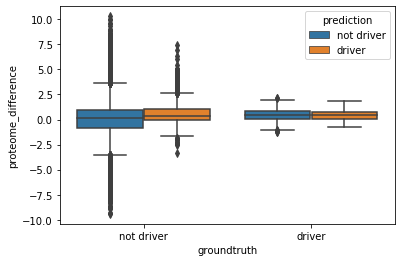

In [71]:
sns.boxplot(data=prob_df, x='groundtruth', y='proteome_difference', hue='prediction')

In [72]:
test_drivers_gt_mask = np.asarray([True if g=='driver' else False for g in prob_df['groundtruth']])
test_nondrivers_gt_mask = ~test_drivers_gt_mask
test_drivers_pred_mask = np.asarray([True if g=='driver' else False for g in prob_df['prediction']])
test_nondrivers_pred_mask = ~test_drivers_pred_mask

In [73]:
booster = model.get_booster()

model_bytearray = booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
booster.save_raw = myfun

# Shap explainer initilization
# shap_ex = shap.TreeExplainer(mybooster)

In [74]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X)

In [75]:
shap_values[test_drivers_gt_mask]

array([[ 0.525821  , -0.7913244 ,  0.27312672, ..., -0.98058486,
         2.2927687 , -0.0765807 ],
       [ 0.37928015,  1.2598978 ,  0.4404965 , ...,  0.6511972 ,
         1.2064991 , -0.10058974],
       [-0.2139642 , -0.04619218, -0.12798968, ..., -0.6847565 ,
         2.1146257 ,  0.715078  ],
       ...,
       [-0.2597158 ,  0.6698962 ,  0.69417864, ..., -0.76525915,
         1.4533132 , -1.811044  ],
       [ 0.5263965 , -0.5017185 ,  1.1342311 , ..., -0.45464662,
         0.96032506, -0.33894688],
       [-0.3993882 , -0.29535377, -0.17086017, ...,  0.24886356,
        -0.50040025,  1.1100411 ]], dtype=float32)

In [76]:
len(test_drivers_gt_mask), test_X.shape

(115931, (115931, 12))

In [77]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[test_drivers_gt_mask], test_X[test_drivers_gt_mask])

In [78]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[test_drivers_gt_mask], test_X[test_drivers_gt_mask])

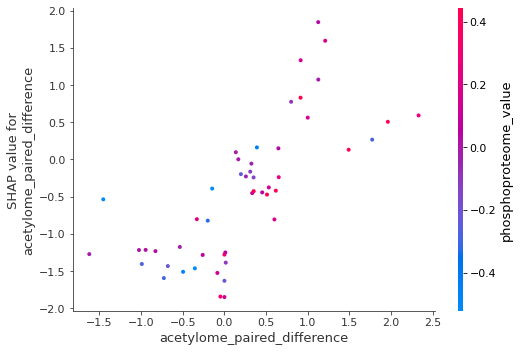

In [92]:
shap.dependence_plot("acetylome_paired_difference", shap_values[:50], test_X.iloc[:50, :])
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'dependence_plot.pdf'))

In [81]:
shap_values[test_drivers_gt_mask], test_X[test_drivers_gt_mask]

(array([[ 0.525821  , -0.7913244 ,  0.27312672, ..., -0.98058486,
          2.2927687 , -0.0765807 ],
        [ 0.37928015,  1.2598978 ,  0.4404965 , ...,  0.6511972 ,
          1.2064991 , -0.10058974],
        [-0.2139642 , -0.04619218, -0.12798968, ..., -0.6847565 ,
          2.1146257 ,  0.715078  ],
        ...,
        [-0.2597158 ,  0.6698962 ,  0.69417864, ..., -0.76525915,
          1.4533132 , -1.811044  ],
        [ 0.5263965 , -0.5017185 ,  1.1342311 , ..., -0.45464662,
          0.96032506, -0.33894688],
        [-0.3993882 , -0.29535377, -0.17086017, ...,  0.24886356,
         -0.50040025,  1.1100411 ]], dtype=float32),
                  acetyl_tumor  acetyl_normal  acetyl_difference  \
 KDM6A_C3L-03962      0.570200      -0.067200           0.637400   
 EP300_C3L-02660     -0.490990      -2.007233           1.516243   
 KMT2D_C3N-01025      1.630446      -0.954115           2.584561   
 EP300_C3L-00568      0.659258      -0.856194           1.515452   
 KDM6A_C3N-03204  

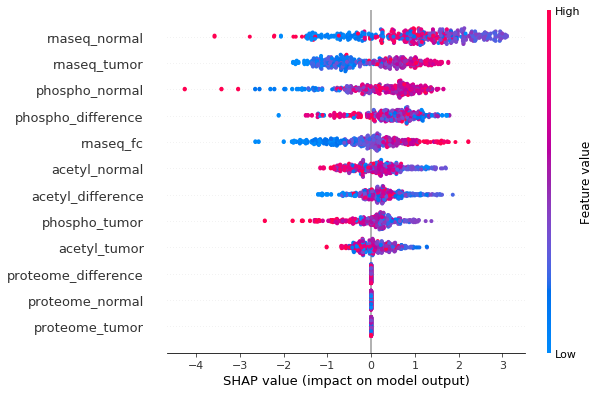

<Figure size 432x288 with 0 Axes>

In [82]:
shap.summary_plot(shap_values[test_drivers_gt_mask], test_X[test_drivers_gt_mask])
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'summary_plot.pdf'))

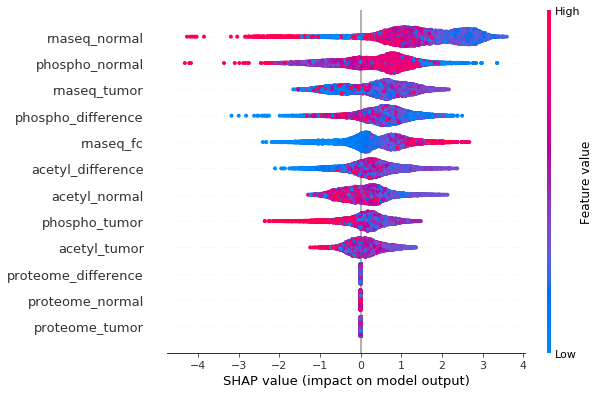

<Figure size 432x288 with 0 Axes>

In [83]:
shap.summary_plot(shap_values[test_drivers_pred_mask], test_X[test_drivers_pred_mask])
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'summary_plot.pdf'))

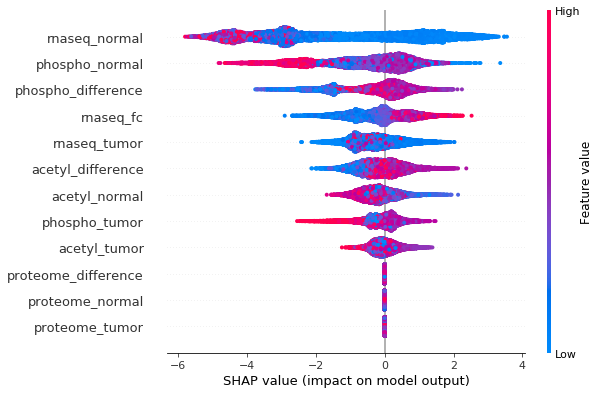

<Figure size 432x288 with 0 Axes>

In [86]:
idxs = np.random.choice(np.arange(test_X.shape[0]), size=20000, replace=False)
shap.summary_plot(shap_values[idxs], test_X.iloc[idxs])
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'summary_plot.pdf'))

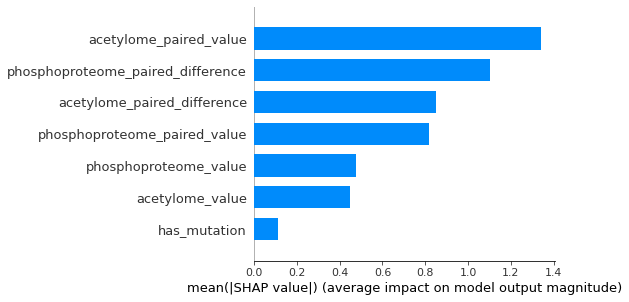

In [94]:
shap.summary_plot(shap_values[:50], test_X.iloc[:50, :], plot_type="bar")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'overall_feature_importances.pdf'))

In [ ]:
X,y = shap.datasets.boston()
# model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

In [ ]:
train_idxs = np.random.choice(np.arange(X.shape[0]), replace=False, size=int(X.shape[0] * .8)).flatten()
val_idxs = np.asarray([x for x in np.arange(X.shape[0]) if x not in train_idxs])

X_train, y_train = X.iloc[train_idxs, :], y[train_idxs]
X_val, y_val = X.iloc[val_idxs, :], y[val_idxs]

In [ ]:
X

In [ ]:
y

In [ ]:
clf = xgb.XGBRegressor(random_state=42)
model = clf.fit(X_train, y_train)

In [ ]:
# model = xgb.fit({"learning_rate": 0.01}, xgb.DMatrix(X[train_idxs], label=y[train_idxs]), 100)

In [ ]:
booster = model.get_booster()

model_bytearray = booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
booster.save_raw = myfun

# Shap explainer initilization
# shap_ex = shap.TreeExplainer(mybooster)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)